# Classifiers as Annotators

In [1]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from annotlib import ClassifierBasedAnnot

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Annotators can be seen as human classifiers. Hence, we use classifiers based on machine learning techniques to represent these annotators. Given a data set comprising samples with their true labels, a classifier is trained on a subset of sample-label-pairs. Subsequently, this trained classifier is used as proxy of an annotator. As a result, the labels for a sample are provided by this classifier as well as the confidence scores which are the posterior probability estimates for the predicted class label.
This simulation techniques is implemented by the class [ClassifierBasedAnnot](../annotlib.classifier_based.rst) and offers many possibilities to affect the labelling performances of the simulated annotators. We describe the following options:

- vary the size of the training set,
- vary the number of the features used for training,
- vary the classifier type and its parametrisation.

Before describing these options, we create a two-dimensional (`n_features=2`) artificial data set comprising `n_samples=300` samples of `n_classes=4` different classes.

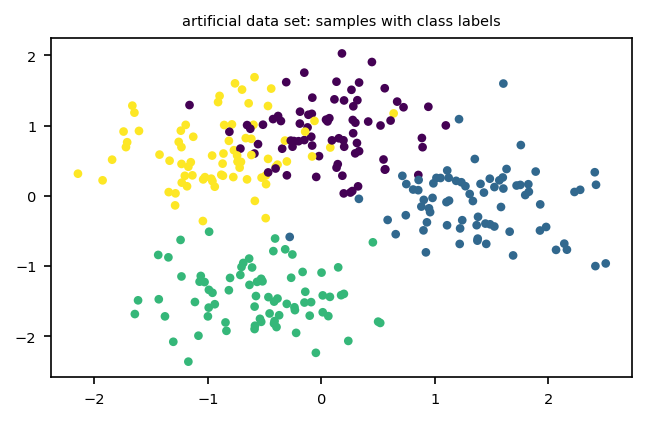

In [2]:
X, y_true =  make_blobs(n_samples=300, centers=4, cluster_std=3, random_state=42)
X = StandardScaler().fit_transform(X)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=10)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

## Varying the Size of the Training Set
To vary the size of the training set, the user is required to specify the parameter `train_ratios`. It controls the ratio of the samples of a class used for training the classifier of an annotator. This input parameter can be either a string or an array. To define the ratio values manually, the user creates an array of the shape `(n_annotator, n_classes)`. An entry `train_ratios[2, 1]` indicates that 30% of the samples of class $y_1$ are randomly selected and used to train the classifier of annotator $a_2$.

The specification as string results in creating preconceived implementations. The first string option is `class_experiences = 'one-hot'`, which induces that each annotator is an expert on a single class meaning the corresponding classifier uses all samples of this class for training. In contrast, the ratio of samples for the remaining classes is 0.2 or 20%. The second string option is `class_experiences = 'equidistant'`, so that each annotator's classifiers has the same ratio of training samples for each class. However, the annotator's classifiers differ in the ratio values. The ratio values of the annotators are evenly spaced among the interval $[\frac{1}{A}, 1]$, where $A$ denotes the number of annotators (`n_annotators`).

In this example, we show the manual definition of the `train_ratios`, where we create two annotators. Annotator $a_0$ is represented by a classifier trained on 0% of class $y=0$, 50% of class $y=1$ as well as class $y=2$, and 100% of class $y=3$, whereas the classifier of annotator $a_1$ is trained on all available samples.

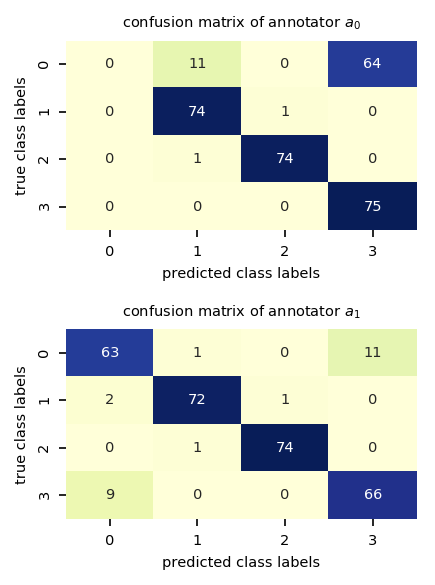

In [3]:
# manually defined train ratios for two annotators and four classes
train_ratios = [[0., .5, .5, 1.],
                [1., 1., 1., 1.]]

# simulate annotators as classifier trained with specified train ratios
tr_ratio_annot = ClassifierBasedAnnot(X=X, y_true=y_true, n_annotators=2, 
                                      train_ratios=train_ratios, 
                                      random_state=42)

# plot resulting confusion matrices
y_unique = np.unique(y_true)
tr_ratio_annot.plot_labelling_confusion_matrices(X=X, y_true=y_true,
                                                 y_unique=y_unique, 
                                                 figsize=(3, 2), 
                                                 fontsize=7)
plt.tight_layout()
plt.show()

The two confusion matrices plotted above indicate the labelling performances of the two simulated annotators whose classifiers are instances of `sklearn.svm.SVC` (support vector machine for classification) by default. Annotator $a_1$ makes only a few mistakes. In contrast, the labelling performance of annotator $a_0$ is worse. First, this annotator's classifier is not trained on all samples but only on a smaller subset. Second, the corresponding training set does not contain a single sample of class $y=0$, so that the classifier of annotator $a_0$ does not know this class. As a result, the classifier never predicts class $y=0$ for a sample (each cell is zero for the prediction column of class $y=0$ in the confusion matrix of annotator $a_0$).

## Varying the Number of the Features Used for Training
Next to altering the training set, the classifiers of the annotators may be also trained on different subspaces of the original feature space. The motivation of such an approach is the emulation of annotators who consider different features to provide a class label for a sample. To implement this functionality, the user is able to manually define the features for each classifier. For this purpose, the parameter `features` is to be defined, which is an array of boolean entries with the shape `(n_annotator, n_features)`. On the one hand, an entry `features[1, 3] = False` indicates that the feature $x_3$ is not considered for training the classifier of annotator $a_1$. On the other hand, the entry `features[0, 1] = True` means that the classifier of annotator $a_0$ has access to the feature $x_1$.  

As an example, we allow the annotator $a_0$ to use both features $x_0$ and $x_1$ and the annotator $a_1$ is restricted to the consideration of the feature $x_0$. Both classifiers are trained on all available samples. The annotator $a_0$ makes less prediction errors than annotator $a_1$, whose classifier tries to find the decision boundaries in the space of feature $x_0$. However, the problem cannot be separated in this subspace.

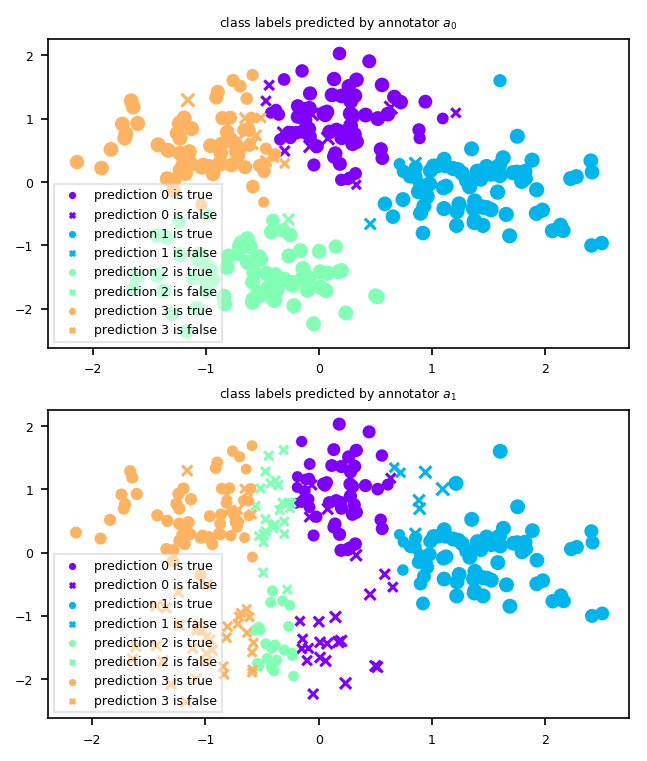

In [4]:
# annotator a_0 considers feature x_0 and x_1, 
# whereas annotator a_1 considers only feature x_0
features = [[True, True],
            [True, False]]

# classifiers are trained on all available samples
train_ratios = np.ones((2, 4))

# simulate annotators
feature_annot = ClassifierBasedAnnot(X=X, y_true=y_true, n_annotators=2, 
                                     train_ratios=train_ratios, 
                                     features=features, 
                                     random_state=42)

# plot samples with the class labels and certainty scores of the annotators
feature_annot.plot_class_labels(X=X, y_true=y_true, plot_confidences=True, 
                                fontsize=6)
plt.show()

## Varying the Classifier Type and its Parametrisation
The use of different classifier types intends to simulate annotators with different assumptions and expertise regarding the making of decisions (predicting a class label). To define an annotator's classifier, the user is required to specify the parameter `classifiers`. This parameter is either a single sklearn classifier supporting `predict_proba(...)` or a list of such classifiers. If the parameter is not a list, each annotator is simulated on the same type of classifier, whereas if it is a list, the annotators may be simulated on different classifier types or different parametrisations. The default classifiers parameter is a list of SVMs with the same parametrisation for each annotator.

To illustrate, how the simulation of annotators based on different classifiers works, three annotators are simulated in the example below. The resulting three annotators have slightly different labelling accuracies (it is a very simple data set), although each classifier is trained on the same training data. Hence, by using different classifier types, the user is able to simulate different decision making of the annotators.

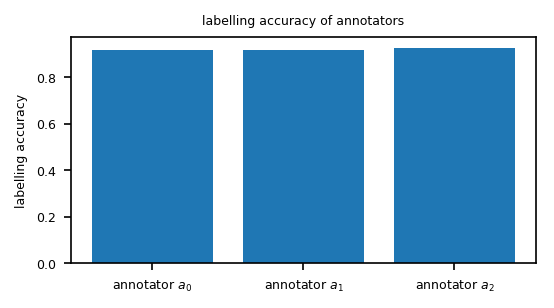

In [5]:
# classifier of each annotator uses 100% of the data for training
train_ratios = [[1, 1, 1, 1],
                [1, 1, 1, 1],
                [1, 1, 1, 1]]

# annotator a_0 is based on gaussian process classifier
gpc = GaussianProcessClassifier(random_state=42)

# annotator a_1 is based on a SVM classifier
svm = SVC(probability=True, random_state=42)

# annotator a_2 is based on a kNN classifier
knn = KNeighborsClassifier()

# create list of classifiers
classifiers = [gpc, svm, knn]

# simulate annotators represented by the specified classifiers
classifier_types_annot = ClassifierBasedAnnot(X=X, y_true=y_true, 
                                              classifiers=classifiers, 
                                              train_ratios=train_ratios, 
                                              n_annotators=3, random_state=42)

# plot the labelling accuracy of each annotator
classifier_types_annot.plot_labelling_accuracy(X=X, y_true=y_true, 
                                               figsize=(4, 2), fontsize=6)
plt.show()

The aforementioned options to simulate annotators can be combined, so that the user is able to define annotators with different experiences, different considered sets of features, and different types of decision makings.